In [2]:
# Find Lanle line pipeline: processing image
# 01) Covert Driving image from RGB to gray scale
# 02) Apply a slight gaussian blur to gray scale image
# 03) Perform Canny edge detection
# 04) Define a region of interest and remove the undesired portions of image
# 05) Retrieve Hough lines
# 06) Apply lines to the original image
# 07) Find the Average slope of lines and points that make the lines and draw the lines.
# Anthony Tran.

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import sys
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
import math
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [5]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [6]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
  
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def find_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

In [37]:
def draw_lines (img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    [  0, 540],
       [360, 337],
       [600, 337],
       [960, 540]], dtype=int32)]
    """
   
    neg_line_x = [] ; neg_line_y = []
    pos_line_x = [] ; pos_line_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            m = find_slope (x1, y1, x2, y2)          
            if (m < 0.0) : 
                #neg_slope.append(m)
                if (m > -0.2):
                    continue
                neg_line_x.append(x1); neg_line_y.append(y1)
                neg_line_x.append(x2); neg_line_y.append(y2)              
            else :       
                #pos_slope.append(m)
                if (m  < 0.2):
                    continue
                pos_line_x.append(x1); pos_line_y.append(y1)
                pos_line_x.append(x2); pos_line_y.append(y2)
   
    # The for loop above collect the slope m (y = mx +b) for the two lanes
    # In order to draw the line we need to find 2 end point for each line
    # (m1_x, m1_y) (m2_x, m2_y)
    # (m3_x, m3_y) (m4_x, m4_y)
    # we do not need to use the average slope, we use polyfit to fit the line.
    #
    color2 = color; [255, 255, 102]
    if (not ((len(neg_line_y)== 0) or (len(neg_line_x)== 0) )) :
        y_fit_neg = np.polyfit(neg_line_y,neg_line_x,1)
        y_fit_fn = np.poly1d(y_fit_neg)
        m1_y = image.shape[0];   m1_x = int(y_fit_fn(m1_y))
        m2_y = 320; m2_x = int(y_fit_fn(m2_y))
        cv2.line(img, (m1_x, m1_y), (m2_x, m2_y), color2, thickness) 
        
    if (not ((len(pos_line_y) == 0) or   (len(pos_line_x) == 0))) :
        y_fit_pos = np.polyfit( pos_line_y,pos_line_x, 1)
        y_fit_fp = np.poly1d(y_fit_pos)
        m3_y = image.shape[0];   m3_x = int(y_fit_fp(m3_y))
        m4_y = 320; m4_x = int(y_fit_fp(m4_y))
        cv2.line(img, (m3_x, m3_y), (m4_x, m4_y), color2, thickness) 

In [38]:
# My Helping function
def read_image_file (file_name):
        return (mpimg.imread(file_name))

In [39]:
def process_image1 (image):
    # Step #1 : 
    
    xsize = xmax = image.shape[1]
    ysize = ymax = image.shape[0]    
    
    grayImage = grayscale (image)
    blur_grayImage = gaussian_blur(grayImage, kernel_size = 5)
    low_threshold = 50
    high_threshold = 150 #250

    edges = canny(blur_grayImage, low_threshold, high_threshold)
    # Step #2 :

    #pts = np.array([[(0,ymax),(xmax*3/8, ymax*5/8), (xmax*5/8,ymax*5/8),(xmax,ymax)]], np.int32) # not working out
    imshape = image.shape
    pts = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32) 
    
    region_interest_img = region_of_interest (edges, pts)
    result = region_interest_img
    
    return result


In [40]:
def process_image2 (region_interest_img):
    # #####################################
    rho = 1
    theta = np.pi/180
    threshold = 20 # 100
    min_line_length = 25 #5 #25# 5 #100
    max_line_gap = 10 #150 #50
    
    image_lines = hough_lines(region_interest_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    return image_lines

In [41]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    region_interest_img = process_image1 (image)
    #plt.imshow (region_interest_img)
    lines = process_image2 (region_interest_img)
    #plt.imshow (lines)
    combo = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return combo

In [42]:
#
file_name = "test_images/solidYellowCurve2.jpg"
image = read_image_file (file_name)

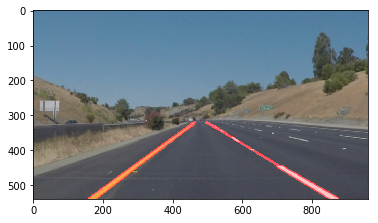

In [43]:
plt.imshow (process_image ( image))

In [44]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:30<00:00,  7.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 8.65 s, sys: 1.05 s, total: 9.7 s
Wall time: 35.7 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [46]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:44<00:00,  6.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 27.1 s, sys: 3.1 s, total: 30.2 s
Wall time: 1min 48s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [50]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [01:17<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 20.1 s, sys: 3.17 s, total: 23.3 s
Wall time: 1min 27s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))